In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
def G(x, y, k):
    g1 = np.sin(k*x)*np.exp(1j*k*y)/k
    g2 = np.sin(k*y)*np.exp(1j*k*x)/k
    return (x<=y)*g1 + (x>y)*g2

def dG(x, y, k):
    g1 = np.cos(k*x)*np.exp(1j*k*y)
    g2 = 1j*np.sin(k*y)*np.exp(1j*k*x)
    return (x<=y)*g1 + (x>y)*g2


def Kernel(x, k, method='exact'):

    n = len(x)
    K = np.zeros((n,n),dtype=complex)
    
    for i in range(n):
        for j in range(n):
            if method=='numerical':
                Ir = lambda s : np.real(dG(s, x[j], k)*np.conj(dG(s, x[i], k)))
                Ii = lambda s : np.imag(dG(s, x[j], k)*np.conj(dG(s, x[i], k)))
            
                K[i,j] = integrate.quad(Ir,0,1)[0] + 1j*integrate.quad(Ii,0,1)[0]
            else:
                s = lambda x : np.sin(k*x)
                c = lambda x : np.cos(k*x)
                e = lambda x : np.exp(1j*k*x)
                
                df = lambda i,j : np.conj(e(x[j]))*(k*x[i]*c(x[i]) + (1-1j*k*x[j])*s(x[i]))/(2*k)             
                t  = lambda i   : s(x[i])*e(1)
                dt = lambda i   : e(1)*(x[i]*c(x[i]) + 1j*s(x[i]))
                    
                if x[i] <= x[j]:
                    K[i,j] = np.real(df(i,j)) + (.5j)*(t(j)*np.conj(dt(i)) - dt(j)*np.conj(t(i)))
                else:
                    K[i,j] = np.real(df(j,i)) + (.5j)*(t(j)*np.conj(dt(i)) - dt(j)*np.conj(t(i)))
    
    return K

def Objective(c, c_ref, k, x, rho = 1, flag = 0):
    xx, yy = np.meshgrid(x,x)
    
    Dsim = np.conjugate(G(xx, yy, k / c))
    Dref = np.conjugate(G(xx, yy, k / c_ref))
    
    E = np.matrix(Dsim - Dref)
    
    if flag == 0:
        W = np.eye(len(x))
    elif flag == 1:
        K = Kernel(x,k/c)
        W = np.linalg.inv(np.eye(len(x)) + (1/rho)*K)
    else:
        K = Kernel(x,k/c_ref)
        W = np.linalg.inv(np.eye(len(x)) + (1/rho)*K)
    
    return np.real(np.trace(E.H@W@E))

In [3]:
n = 10
x = np.linspace(0,1,n+2)[1:-1]
k = 5
c_ref = 1

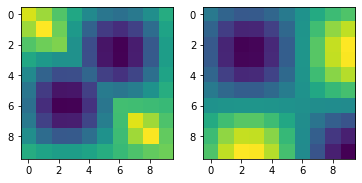

In [4]:
xx, yy = np.meshgrid(x,x)
D = np.conjugate(G(xx, yy, k/c_ref))

fig, ax = plt.subplots(1,2)

ax[0].imshow(np.real(D))
ax[1].imshow(np.imag(D))

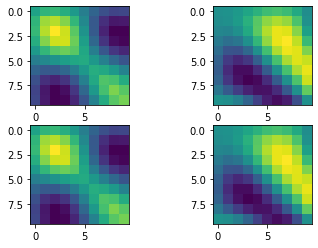

In [5]:
Kn = Kernel(x,k/c_ref,method='numerical')
K  = Kernel(x,k/c_ref)

fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(Kn))
ax[0,1].imshow(np.imag(Kn))

ax[1,0].imshow(np.real(K))
ax[1,1].imshow(np.imag(K))

In [6]:
np.linalg.norm(Kn-K,ord='fro') / np.linalg.norm(Kn,ord='fro')

2.568971050297184e-09

# Objectives


In [14]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
def basexp(f):
    t = np.log10(f)
    e = int(np.sign(t)*(np.ceil(np.abs(t))))
    b = f*10**(-e)
    
    return b,e 
def make_plot(n, k, rho, ax, xlabel=True, ylabel=True):
    
    c_ref = 1

    x  = np.linspace(0,1,n+2)[1:-1]
    cs = c_ref * np.linspace(.8, 1.2, 100)

    phi0 = np.zeros(len(cs))
    phi1 = np.zeros(len(cs))
    phi2 = np.zeros(len(cs))

    for i in range(len(cs)):
        phi0[i] = Objective(cs[i], c_ref, k, x, rho = 1, flag = 0)
        phi1[i] = Objective(cs[i], c_ref, k, x, rho = rho, flag = 1)
        phi2[i] = Objective(cs[i], c_ref, k, x, rho = rho, flag = 2)
    
    ax.plot(cs, phi0/np.sum(phi0), 'k--', label='conventional')
    ax.plot(cs, phi1/np.sum(phi1), label='variable metric')
    ax.plot(cs, phi2/np.sum(phi2), label='data-driven metric')
    if xlabel:
        ax.set_xlabel(r'$c$')
    if ylabel:
        ax.set_ylabel(r'$J(c)$')

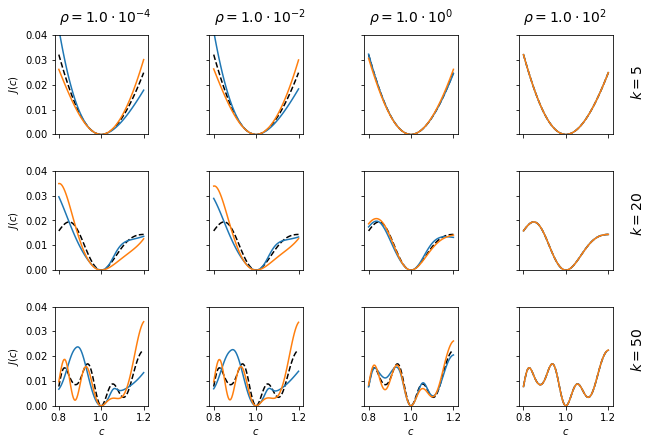

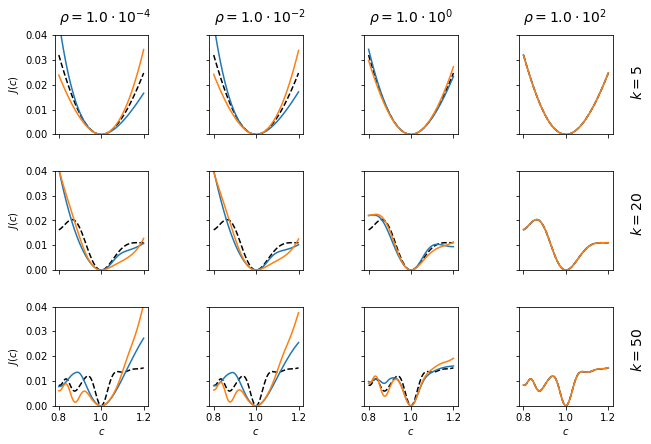

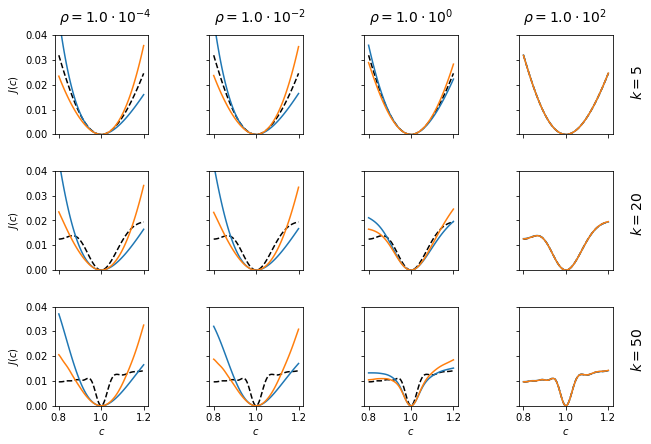

In [50]:
for n in [2, 5, 10]:
    ks   = [5, 20, 50]
    rhos = [1e-4, 1e-2, 1, 1e2]

    fig, ax = plt.subplots(len(ks), len(rhos), sharey=True, sharex=True)
    for i in range(len(ks)):
        for j in range(len(rhos)):
            make_plot(n, ks[i], rhos[j], ax[i,j], xlabel=(i==2), ylabel=(j==0))
            ax[i,j].set_ylim([0,0.04])
    for j in range(len(rhos)):
        ax[0,j].text(.8,.045,r'$\rho = %1.1f\cdot 10^{%d}$'%(basexp(rhos[j])[0], basexp(rhos[j])[1]),fontsize=14)

    for i in range(len(ks)):
        ax[i,len(rhos)-1].text(1.3,.015,r'$k = %d$'%(ks[i]),fontsize=14,rotation='vertical')

    fig.tight_layout()
    fig.set_figwidth(10)
    fig.set_figheight(7)

    plt.savefig('Helmholtz1D_%d'%n,dpi=300)